<a href="https://colab.research.google.com/github/catPotat/rn-hg-gpt2-playground/blob/main/Huggingface_GPT_2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

Author: *N H Long*

This notebook is about testing GPT-2's ability to aid creativities.

This notebook is dedicated to the SS2 class I'm taking now.

The dateline for a published research is on the 7th of May (more info later).

<br>

---

<br>
<img src="https://i.redd.it/j586af7nxvu41.jpg" alt="Watching a train model" height=300>

# 🏁 Initialize

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Feb  2 06:35:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
# !pip install datasets
# !pip uninstall tensorflow
!pip install python-dotenv
from google.colab import output
output.clear()
import os
from dotenv import load_dotenv
!cp 'drive/My Drive/.env.gdrive' '.env'
load_dotenv()

True

# 🔧 Tuning

## 🍃 Obtaining data

In [ ]:
MONG_USER = os.getenv('MONG_ROUSER')
MONG_PWD  = os.getenv('MONG_ROPWD')
MONG_HOST = os.getenv('MONG_HOST')
MONG_PORT = os.getenv('MONG_PORT')

from pymongo import MongoClient
from bson.objectid import ObjectId

uri = f"mongodb://{MONG_USER}:{MONG_PWD}@{MONG_HOST}:{MONG_PORT}/dataDumpingGround"
client = MongoClient(uri)
db = client['dataSoup']
db

Database(MongoClient(host=['171.244.50.232:27017'], document_class=dict, tz_aware=False, connect=True), 'dataSoup')

### a) english pokedex

In [ ]:
dataSoup_col = db["pot1"]
pokedex_text_entries_plain = dataSoup_col.find_one({'name': 'pokedex text_entries_plain'})

In [ ]:
text_entries = pokedex_text_entries_plain['content']
# text_entries

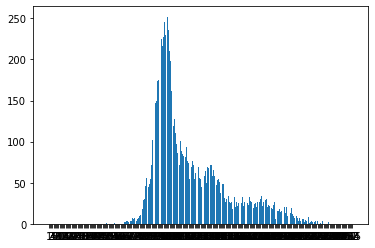

In [ ]:
entry_len = {}
for x in range(255):
    entry_len[x+1] = 0
 
for entry in text_entries:
    # if text_len := len(entry) in entry_len:
    text_len = len(entry)
    if text_len in entry_len:
        entry_len[text_len] += 1
    else:
        entry_len[text_len] = 1
entry_len
 
import matplotlib.pyplot as plt

plt.bar(range(len(entry_len)), list(entry_len.values()), align='center')
plt.xticks(range(len(entry_len)), list(entry_len.keys()))
plt.show()

### b) bill wurtz' tweets

In [ ]:
tw_profile_col = db["twitterProfiles"]
tw_profile = tw_profile_col.find_one({'screen_name': 'billwurtz'})
tw_profile

In [ ]:
from pprint import pprint
import re
from sys import maxsize as inf
text_entries = []
LIMIT = inf

tweet_col = db["twitterTweets"]
tweet_cursor = tweet_col.find({'Author_id': 289853473})
for tweet in tweet_cursor.limit(LIMIT):
    # pprint(tweet)
    text = tweet.get('full_text')
    if text.startswith('RT @'):
        continue
    text = re.sub(r'\@(.*?)\ ', '', text)
    text = re.sub(r'\#(.*?)\ ', '', text)
    text = re.sub(r'(https?:\/\/t.co\/)(.*)', '', text)
    text = re.sub(r'\n\nbill wurtz', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\'', '', text)
    text_entries.append(text)
 
text_entries

[]

Visualize our data

In [ ]:
entry_len = {}
for x in range(140):
    entry_len[x+1] = 0
 
for entry in text_entries:
    text_len = len(entry)
    if text_len in entry_len:
        entry_len[text_len] += 1
    else:
        entry_len[text_len] = 1
entry_len
 
import matplotlib.pyplot as plt
 
plt.bar(range(len(entry_len)), list(entry_len.values()), align='center')
plt.xticks(range(len(entry_len)), list(entry_len.keys()))
plt.show()

KeyboardInterrupt: ignored

### c) pictures as text

[pkm refs](https://colab.research.google.com/drive/1SdgyibJJKpPmMFX9UD1r7ZOZJHJfbm1z?authuser=2#scrollTo=oLfKBltYZVeq)

In [ ]:
!mkdir -p datasets/{fragments,all-pics}/
!unzip "drive/My Drive/datasets/Eeveelutions/sap1231-251020.zip" -d datasets/fragments/
!unzip "drive/My Drive/datasets/Eeveelutions/evhub#evlution-pics.zip" -d datasets/fragments/
output.clear()

In [ ]:
import os
import shutil
from tqdm import tqdm
IMAGES_PATH = 'datasets/all-pics/'
IMAGES_PATH

'datasets/all-pics/'

In [ ]:
for root, dirs, files in tqdm( os.walk('./datasets/', topdown=False) ):
    for name in files:
        if 'SoloEevee/Umbreon' not in root: continue
        # if 'NotEevee' in root: continue
        # if 'Grouped' in root: continue
        file_path = os.path.join(root, name)
        # print(file_path)
        shutil.copyfile(file_path, os.path.join(IMAGES_PATH, name))

108it [00:02, 41.04it/s]


In [ ]:
from PIL import Image
import math

IMG_WIDTH = 64
IMG_HEIGHT = 64
LINE_SPLIT_CHAR = '.'
PIXEL_SPLIT_CHAR = ''
IMAGE_SPLIT_CHAT = '\n'
CHAR_CODE_SHIFT = 33
IMG_TXT_PATH = f'drive/My Drive/datasets/Eeveelutions/all-images-{IMG_WIDTH}.txt'

In [ ]:
text_entries = []
for f in tqdm( os.listdir(IMAGES_PATH) ):
    if f.split('.')[-1] not in ['png', 'gif', 'jpg', 'jpeg']:
      continue
    image = Image.open(os.path.join(IMAGES_PATH, f)).convert('RGBA')
    # ratio check
    rtio = image.size[0] / image.size[1] # width/height
    gndRtio = IMG_WIDTH / IMG_HEIGHT
    if rtio > gndRtio*1.6 or rtio < 1/gndRtio*0.7:
        continue
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    pixels = image.load()
    lines = []
    for y in range(IMG_HEIGHT):
        split = []
        for x in range(IMG_WIDTH):
            s = '~'
            color = pixels[x, y]
            if len(color) < 4 or color[3] > 128:
                r, g, b = color[0:3]
                mR = math.floor(r/64) # 6-bit color
                mG = math.floor(g/64)
                mB = math.floor(b/64)
                c = 0;
                c += mR
                c = c << 2
                c += mG
                c = c << 2
                c += mB
                s = chr(c+CHAR_CODE_SHIFT)
            split.append(s)
        lines.append(PIXEL_SPLIT_CHAR.join(split))
    out_ = LINE_SPLIT_CHAR.join(lines)
    text_entries.append(out_)
    mirrored = LINE_SPLIT_CHAR.join(
        [l[::-1] for l in lines]
    )
    text_entries.append(mirrored)
    
with open(IMG_TXT_PATH, 'w+') as f:
    f.write(IMAGE_SPLIT_CHAT.join(text_entries))

100%|██████████| 630/630 [00:34<00:00, 18.10it/s]


In [ ]:
with open(IMG_TXT_PATH, 'r') as f:
    content = f.read()
    text_entries = content.split(IMAGE_SPLIT_CHAT)

# text_entries

## 🧼 Processing

In [ ]:
TRAIN_PATH = 'train_dataset.txt'
TEST_PATH = 'test_dataset.txt'
MODEL_NAME = "distilgpt2"
SAVE_MODEL_PATH = 'drive/MyDrive/model-checkpoints/gpt2-umbrpics/'

### 📄 Build txt file

In [ ]:
from sklearn.model_selection import train_test_split

train_ds, test_ds = train_test_split(text_entries, test_size=0.01, shuffle=True) 

print(f"Train dataset length: {len(train_ds)}")
print(f"Test dataset length: {len(test_ds)}")

Train dataset length: 1098
Test dataset length: 12


In [ ]:
longest_len = 0

def build_text_files(lines, dest_path):
    global longest_len
    f = open(dest_path, 'w+')
    data = ""
    for line in lines:
        data += line + IMAGE_SPLIT_CHAT
        
        # assign max length
        if len(line) > longest_len:
            longest_len = len(line)
    f.write(data)

build_text_files(train_ds, TRAIN_PATH)
build_text_files(test_ds, TEST_PATH)

### 🪓 Tokenizer

#### a) Train a tokenizer

[văn bản liên kết](https://huggingface.co/blog/how-to-train)

In [ ]:
TOK_PATH = SAVE_MODEL_PATH + "tok/"

In [ ]:
from tokenizers import ByteLevelBPETokenizer

tok_trainer = ByteLevelBPETokenizer()
tok_trainer.train(files=[TRAIN_PATH, TEST_PATH],
                vocab_size=2000, min_frequency=1,)
!mkdir -p 'tok/'
tok_trainer.save_model('tok/', "igptkinda")
!mkdir -p $TOK_PATH
!cp 'tok/igptkinda-vocab.json' '$TOK_PATH/vocab.json'
!cp 'tok/igptkinda-merges.txt' '$TOK_PATH/merges.txt'

In [ ]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(TOK_PATH, model_max_length=1200)
tokenizer.encode(" ` [`]")

[220, 63, 220, 592, 60]

#### b) Pretrained

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, model_max_length=longest_len)
tokenizer.encode("Hello world.")

[15496, 995, 13]

### 📚 Turn into dataset

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=TRAIN_PATH,
    block_size=128
)
test_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=TEST_PATH,
    block_size=128
)
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

/usr/local/lib/python3.6/dist-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  FutureWarning,


## 🧠 The model

Get the available $MODEL_NAME model

In [ ]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
# model

## 🚧 Training

API docs: [HG trainer](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments)
[Torch optim](https://pytorch.org/docs/stable/optim.html)


In [ ]:
# Free up momory
import gc
gc.collect()

1286

In [ ]:
from transformers import Trainer, TrainingArguments, get_scheduler
from torch import optim

SAVE_PATH = "/drive/MyDrive/model-checkpoints/gpt2-umbrpics"

training_args = TrainingArguments(
    output_dir=SAVE_PATH,
    overwrite_output_dir=True,
    num_train_epochs=11,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    save_steps=800,
)

In [ ]:
from transformers import Trainer, TrainingArguments, get_scheduler
from torch import optim

training_args = TrainingArguments(
    output_dir=SAVE_PATH,
    overwrite_output_dir=True,
    num_train_epochs=11,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    save_steps=800,
)
# Turn down on memory usage
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = get_scheduler("polynomial", optimizer, num_warmup_steps=1000, num_training_steps=0)


trainer = Trainer(model=model, args=training_args, data_collator=collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # optimizers=(optimizer, scheduler),
)
trainer.train()

Step,Training Loss
500,4.768600
1000,4.515700
1500,4.334700


In [ ]:
trainer.save_model()

# 🧪 Testing

In [ ]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model=SAVE_MODEL_PATH + 'checkpoint-800/',
                     tokenizer=tokenizer)
set_seed(6110)

## a) Text test

In [ ]:
generator("Oh hey you Umbreon! I heard that Umbreon", max_length=40, num_return_sequences=5)

https://github.com/huggingface/transformers/issues/1407

## b) Image test

In [ ]:
CONTRAST = 64
BRIGHTNESS = 24
def reconstruct_from(text, path):
    lines = text.split(LINE_SPLIT_CHAR)
    width = len( max(lines, key=len) ) # IMG_WIDTH
    height = len(lines) # IMG_HEIGHT
    pixels = []
    for y in range(height):
        for x in range(width):
            pixels.append((0, 0, 0, 0))
    for index, line in enumerate(lines):
        line = line.split(PIXEL_SPLIT_CHAR) if PIXEL_SPLIT_CHAR  else line
        for x in range(len(line) - 1):
            s = line[x + 1]
            try:
                if s == '~': continue
                r = g = b = 0
                c = ord(s[0])-CHAR_CODE_SHIFT
                b = (c & 3) * CONTRAST + BRIGHTNESS
                c = c >> 2
                g = (c & 3) * CONTRAST + BRIGHTNESS
                c = c >> 2
                r = (c & 3) * CONTRAST + BRIGHTNESS
                i = (index*width) + x
                pixels[i] = (r, g, b, 255)
            except: 
                print('fuck')
    image = Image.new('RGBA', (width, height))
    image.putdata(pixels)
    image.save(path)
    return image
# reconstruct_from(text_entries[-1], "test.png")

In [ ]:
genner = generator("", max_length=950, num_return_sequences=1)
img = genner[0]['generated_text'].strip()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
reconstruct_from(img, "generated.png")